In [51]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import IPython
import time
import sys

import sklearn
from sklearn import preprocessing
from sklearn import datasets 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.manifold import TSNE

import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, Dropout2d
import torch.optim as optim
import torchvision
from torchvision.transforms import *

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z
/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar10/data_batch_4
/kaggle/input/cifar10/data_batch_5
/kaggle/input/cifar10/data_batch_1
/kaggle/input/cifar10/data_batch_3
/kaggle/input/cifar10/data_batch_2
/kaggle/input/cifar10/test_batch


In [52]:
#data sets path
DATA_PATH = '/kaggle/input/cifar10/'
IMAGE_PATH = 'image/'

In [53]:
#print progress bar
def progress(count, total, suffix=''):
    bar_len = 30
    filled_len = int(round(bar_len * count / float(total)))
    
    percents = 100 * count // total
    bar = '=' * filled_len +'>'+ '.' * (bar_len - filled_len)
    if percents == 100:
        bar = '=' * filled_len +'='+ '.' * (bar_len - filled_len)
    length = len(str(total))
    sys.stdout.write('%s/%s [%s]%s%% %s\r' % (('{:>%s}'%length).format(count), total, bar, '{:>3}'.format(percents), suffix))
    sys.stdout.flush()

#plot images    
def plot_image(X):
    plt.figure(figsize=(50,5))
    for i,x in enumerate(X[:10]):
        plt.subplot(1,10,i+1)
        try:
            plt.imshow(np.array(x))
        except:
            plt.imshow(np.array(x).transpose(1,2,0))
    
def dimension_reduction(x_train, x_test, n_components):
    print("Reducting dimensions...")
    pca = PCA(n_components=n_components, random_state=33)
    pca.fit(x_train)
    x_train= pca.transform(x_train)
    x_test = pca.transform(x_test)
    return x_train, x_test, pca

#load data from local disk
def load_CIFAR_10(training_batches=5, test_batches=1):
    X_train=y_train=X_test=y_test = None
    for b in range(1,training_batches+1):
        with open(DATA_PATH+'data_batch_%s'%b,'rb') as file:
            data = pickle.load(file,encoding='bytes')
            X = np.array(data[b'data'])
            y = np.array(data[b'labels'])
            try:
                X_train = np.concatenate((X_train,X))
                y_train = np.concatenate((y_train,y))
                print('train set batch: %d'%b)
            except:
                print('train set batch: %d'%b)
                X_train = X
                y_train = y
                
    for b in range(1,test_batches+1):
        with open(DATA_PATH+'test_batch','rb') as file:
            data = pickle.load(file,encoding='bytes')
            X = np.array(data[b'data'])
            y = np.array(data[b'labels'])
            try:
                X_test = np.concatenate((X_test,X))
                y_test = np.concatenate((y_test,y))
            except:
                print('test set batch: %d'%b)
                X_test = X
                y_test = y
    return X_train,y_train,X_test,y_test

# PCA Projection


In [54]:
def scatter_two_component(comp1,comp2,y_train,classes,save_as):
    plt.figure(figsize=(20,15))
    color_map = plt.cm.get_cmap('Accent')
    
    #plot without labels (faster)
    plt.scatter(comp1,comp2,c=y_train,cmap=color_map)

    #plot labels
    labels = np.array(classes)[y_train]
    class_num = set()
    for x1,x2,c,l in zip(comp1,comp2,color_map(y_train),labels):
        if len(class_num)==10:
            break
        plt.scatter(x1,x2,c=[c],label=l)
        class_num.add(l)
        
    #remvoe duplicate labels    
    hand, labl = plt.gca().get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    plt.title(save_as)
    plt.xlabel('Component One')
    plt.ylabel('Component Two')
    plt.legend(handout, lablout,fontsize=20)
    plt.savefig(IMAGE_PATH+save_as)
    plt.show()

# X_train,y_train,X_test,y_test = load_CIFAR_10()
# X_train,X_test,pca = dimension_reduction(X_train,X_test,n_components=50)

# pca.explained_variance_ratio_

# scatter_two_component(X_train[:,0],X_train[:,1],y_train,classes,'PCA')

# t-SNE Embedding

In [55]:
# try:
#     with open('X_embedded','rb') as file:
#         X_embedded = pickle.load(file)
# except:
#     X_embedded = TSNE(n_components=2).fit_transform(X_train)
#     with open('X_embedded','wb') as file:
#         pickle.dump(X_embedded,file)

# scatter_two_component(X_embedded[:,0],X_embedded[:,1],y_train,classes,'t-SNE')

# CNN

In [56]:
X_train,y_train,X_test,y_test = load_CIFAR_10()

X_train = torch.tensor(X_train.reshape(-1,3,32,32))
X_test = torch.tensor(X_test.reshape(-1,3,32,32))
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
assert type(X_train)==torch.Tensor,"Type(X_train) == Torch.tensor is required, got %s"%type(X_train)
C = X_train.shape[1]
H = X_train.shape[2]
W = X_train.shape[3]

train set batch: 1
train set batch: 2
train set batch: 3
train set batch: 4
train set batch: 5
test set batch: 1


In [57]:
# tranform functions
T = Compose([
    ToPILImage(),
#     CenterCrop(32),
#     ColorJitter(brightness=1, contrast=0, saturation=0, hue=0),
#     Pad(2, fill=(100,100,100), padding_mode='constant'),
#     Grayscale(3),    
    RandomHorizontalFlip(p=0.5),
#     RandomAffine(30, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
#     RandomCrop(32, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
#     RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
#     RandomRotation(10, resample=False, expand=False, center=None),
    RandomResizedCrop(32, scale=(0.75, 1), ratio=(0.75, 1), interpolation=2),
    ToTensor(),
    Normalize((0.4753,0.4623,0.4149), (0.2414,0.236,0.2419)),
#     Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# tranform functions
T2 = Compose([
    ToPILImage(),
#     Grayscale(3),
    ToTensor(),
    Normalize((0.4753,0.4623,0.4149), (0.2414,0.236,0.2419)),
#     Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

In [58]:
X_new = torch.stack([T(x) for x in X_train])
X_train = torch.stack([T2(x) for x in X_train])
X_test = torch.stack([T2(x) for x in X_test])

In [59]:
#augmentation
X_train = torch.stack([X_new,X_train]).reshape(-1,C,H,W)
y_train = torch.stack([y_train,y_train]).reshape(-1,)

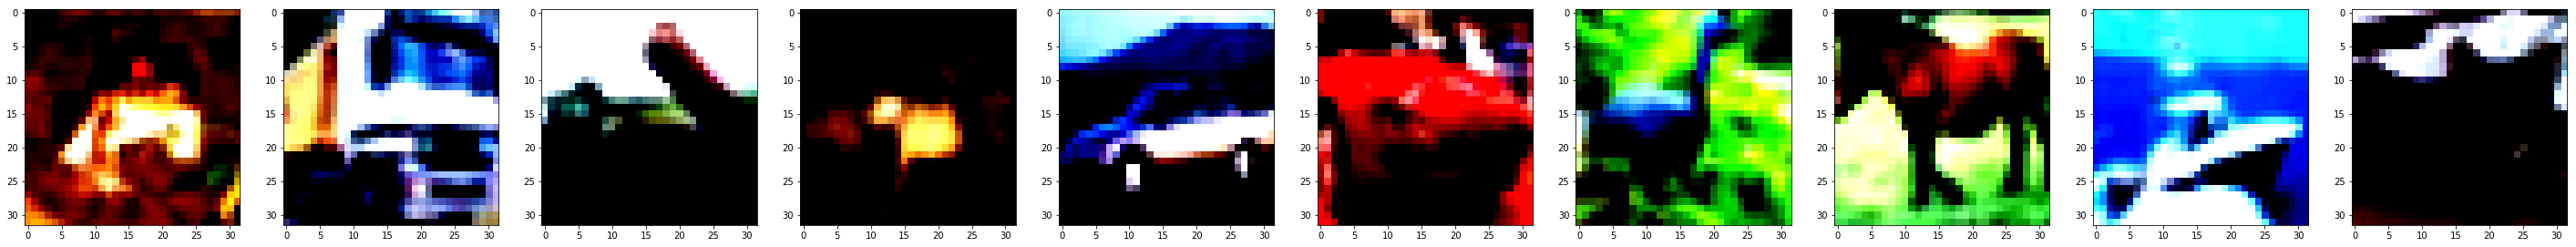

In [60]:
plot_image(X_train)

In [61]:
#cnn parameters
image_channels = X_train.shape[1]
image_width = X_train.shape[2]
num_filters = 32
num_filters2 = 64
num_filters3 = 128
filter_size = 5
pool_size = 2
# final_input = (((image_width+1-filter_size)//pool_size+1-filter_size)//pool_size)**2*num_filters2#without padding
# final_input = (image_width//pool_size//pool_size//pool_size)**2*num_filters3#with padding

class net(Module):   
    def __init__(self):
        super(net, self).__init__()
        self.final_input = 2048
        self.cnn_layers = Sequential(
            Conv2d(image_channels, num_filters, filter_size, padding=filter_size//2),
            ReLU(),
            MaxPool2d(pool_size, pool_size),

            Conv2d(num_filters, num_filters2, filter_size, padding=filter_size//2),
            ReLU(),
            MaxPool2d(pool_size, pool_size),

            Conv2d(num_filters2, num_filters3, filter_size, padding=filter_size//2),
            ReLU(),
            MaxPool2d(pool_size, pool_size),
        )

        self.linear_layers = Sequential(
            Linear(self.final_input, self.final_input//2),
            ReLU(),
            Dropout2d(p=0.5),

            Linear(self.final_input//2, self.final_input//4),
            ReLU(),
            Dropout2d(p=0.5),

            Linear(self.final_input//4, self.final_input//16),
            ReLU(),
            Dropout2d(p=0.5),

            Linear(self.final_input//16,10),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, self.final_input)
        x = self.linear_layers(x)
        return x

In [62]:
def test_model(model,batch_size,test_loader,criterion):
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            X, y = data
            if torch.cuda.is_available():
                X, y = X.cuda(), y.cuda()
            y_proba = model(X)
            loss = criterion(y_proba, y)
            running_loss += loss.item()
            _, y_pred = torch.max(y_proba.data, 1)
            total += y.size(0)
            correct += (y_pred == y).sum().item()
    loss = running_loss/len(test_loader)
    acc = correct/total
    return loss, acc

In [63]:
def test_class_acc(model,test_loader,classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in test_loader:
            X, y = data
            if torch.cuda.is_available():
                X, y = X.cuda(), y.cuda()
            y_proba = model(X)
            _, y_pred = torch.max(y_proba, 1)
            c = (y_pred == y).squeeze()
            for i in range(4):
                label = y[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [64]:
def save_prediction(test_loader):
    with open('results.csv','bw') as file:
        file.write("ImageId,Label\n".encode())
        with torch.no_grad():
            for i, data in enumerate(test_loader, 1):
                X = data[0]
                if torch.cuda.is_available():
                    X = X.cuda()
                y_proba = model(X)
                _, y_pred = torch.max(y_proba.data, 1)
                file.write(pair.encode())    

In [65]:
def train_model(model,batch_size,num_epoch,criterion,optimizer,train_loader,test_loader):
    N = N_test = 0
    for x in train_loader:
        N += x[0].size(0)
    for x in test_loader:
        N_test += x[0].size(0)
    print('Train on %s samples, Test on %s samples'%(N,N_test))
    
    for epoch in range(num_epoch):
        print('Epoch: %s/%s'%(epoch+1,num_epoch))
        total = 0
        correct = 0
        running_loss = 0.0
        start_time = time.time()
        for i, data in enumerate(train_loader, 1):
            X, y = data
#             if device.type != 'cpu':
#                 X, y = X.to(device), y.to(device)
            if torch.cuda.is_available():
                X, y = X.cuda(), y.cuda()
            optimizer.zero_grad()

            # forward + backward + optimize
            y_proba = model(X)
            
            #avg batch acc
            _, y_pred = torch.max(y_proba.data, 1)
            total += y.size(0)
            correct += (y_pred == y).sum().item()
            
            loss = criterion(y_proba, y)
            loss.backward()
            optimizer.step()

            #avg batch loss
            running_loss += loss.item()
            if i == len(train_loader):
                t_loss,t_acc = test_model(model,batch_size,test_loader,criterion)
                progress(total,N,' time:%ss, loss: %.4f, acc: %.4f, test_loss: %.4f, test_acc: %.4f'
                         %('{:>3}'.format('%.f'%float(time.time()-start_time)),running_loss/i,correct/total,t_loss,t_acc))
            else:
                progress(total,N,' time:%ss, loss: %.4f, acc: %.4f'%
                         ('{:>3}'.format('%.f'%float(time.time()-start_time)),running_loss/i,correct/total))
                
#         if (epoch+1) % 10 ==0:
#             torch.save(model.state_dict(), 'model_%s.pt'%(epoch+1))
        sys.stdout.write('\n')
    torch.save(model.state_dict(), 'model.pt')
    print(model)
    print('Training Finished')
    return model

In [66]:
model = net()
if torch.cuda.is_available():
    print('Load model into GPU')
    moedl = model.cuda()

Load model into GPU


In [68]:
# %%time
'''
    Rerun this cell to train the same model multiple epoches.
'''
batch_size=128
num_epoch=10
criterion = CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create torch Dataset class from tensors
train_set = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
if type(y_test) == type(None):#no y_test available, save predictions to disk
    test_set = torch.utils.data.TensorDataset(X_test)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)
else:
    test_set = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
#try to load trained model 
try:
    model.load_state_dict(torch.load('model1.pt'))
    print("Pre-trained model loaded")
    if type(y_test) == type(None):
        save_prediction(test_loader)
        print("Prediction saved")
    else:
        loss,acc = test_model(model,batch_size,test_loader,criterion)
        print('Accuracy of the network on the test set: %.2f%%, loss: %.4f' % (acc*100, loss))
        test_class_acc(model,test_loader,classes)
except:
    print('Model not found, start straining...')
    model = train_model(model,batch_size,num_epoch,criterion,optimizer,train_loader,test_loader)
    test_class_acc(model,test_loader,classes)

Model not found, start straining...
Train on 100000 samples, Test on 10000 samples
Epoch: 1/10
100000/100000 [===============================]100%  time:  8s, loss: 2.2532, acc: 0.1478, test_loss: 2.1100, test_acc: 0.1977
Epoch: 2/10
100000/100000 [===============================]100%  time:  9s, loss: 2.0139, acc: 0.2278, test_loss: 1.8849, test_acc: 0.2679
Epoch: 3/10
100000/100000 [===============================]100%  time:  8s, loss: 1.8312, acc: 0.2990, test_loss: 1.7570, test_acc: 0.3328
Epoch: 4/10
100000/100000 [===============================]100%  time:  8s, loss: 1.7262, acc: 0.3462, test_loss: 1.6542, test_acc: 0.3699
Epoch: 5/10
100000/100000 [===============================]100%  time:  8s, loss: 1.6470, acc: 0.3830, test_loss: 1.5959, test_acc: 0.4020
Epoch: 6/10
100000/100000 [===============================]100%  time:  8s, loss: 1.5752, acc: 0.4134, test_loss: 1.5087, test_acc: 0.4383
Epoch: 7/10
100000/100000 [===============================]100%  time:  8s, loss: 1

# Activation maximization

In [ ]:
def plot_activation_image(target):
    zeros = np.zeros((1,3,32,32)).astype(np.float32)
    gray = zeros+0.5
    X = torch.tensor(gray, requires_grad=True)
    target = torch.empty(1, dtype=torch.long).random_(target,target+1)
    # plot_image(gray)
    criterion = CrossEntropyLoss()

    for i in range(100):
        # y probabilities [p0,p1,...,p9]
        y_proba = model(X)

        #backward
        loss = criterion(y_proba, target)
        loss.backward()

        #minimize loss
        X.data -= 0.2*X.grad.data    

        X.grad.data.zero_()
        
#         if i%10 ==0:
#             IPython.display.display(plt.gcf())       # Tell Jupyter to show Matplotlib's current figure
#             IPython.display.clear_output(wait=True)  # Tell Jupyter to clear whatever it's currently showing
#             time.sleep(0.02)
    plt.title("Target class: %s"%classes[target])
    plt.imshow(X[0].detach().numpy().transpose(1,2,0))
#     plt.savefig(IMAGE_PATH+classes[target]+'_activation')
    print('finished')

In [ ]:
model = model.cpu()
plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plot_activation_image(i)
plt.show()